# Cluster Aggregation

This tutorial shows how to aggregate clusterings across models/variables/etc.


In [1]:
# Prerequisites
from toad import TOAD
from sklearn.cluster import HDBSCAN  # type: ignore
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# start by initiating TOAD
td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")
td.data = td.data.coarsen(x=2, y=2, GMST=2, boundary="trim").reduce(np.mean)
td.data = td.data.drop_vars(td.cluster_vars)

Compute some different clusterings, here using different time-scale factors


In [3]:
td.data = td.data.drop_vars(td.cluster_vars)
tsf_range = np.linspace(0.1, 10, 15)
for tsf in tsf_range:
    td.compute_clusters(
        shift_threshold=0.8, method=HDBSCAN(min_cluster_size=10), time_scale_factor=tsf
    )

INFO: New cluster variable thk_dts_cluster: Identified 2 clusters in 2,510 pts; Left behind 0.9% as noise (22 pts).
INFO: New cluster variable thk_dts_cluster_1: Identified 11 clusters in 2,510 pts; Left behind 5.0% as noise (125 pts).
INFO: New cluster variable thk_dts_cluster_2: Identified 21 clusters in 2,510 pts; Left behind 10.9% as noise (274 pts).
INFO: New cluster variable thk_dts_cluster_3: Identified 22 clusters in 2,510 pts; Left behind 9.7% as noise (244 pts).
INFO: New cluster variable thk_dts_cluster_4: Identified 26 clusters in 2,510 pts; Left behind 14.2% as noise (356 pts).
INFO: New cluster variable thk_dts_cluster_5: Identified 26 clusters in 2,510 pts; Left behind 16.9% as noise (425 pts).
INFO: New cluster variable thk_dts_cluster_6: Identified 27 clusters in 2,510 pts; Left behind 14.7% as noise (370 pts).
INFO: New cluster variable thk_dts_cluster_7: Identified 25 clusters in 2,510 pts; Left behind 13.4% as noise (336 pts).
INFO: New cluster variable thk_dts_clus

Let's look at them


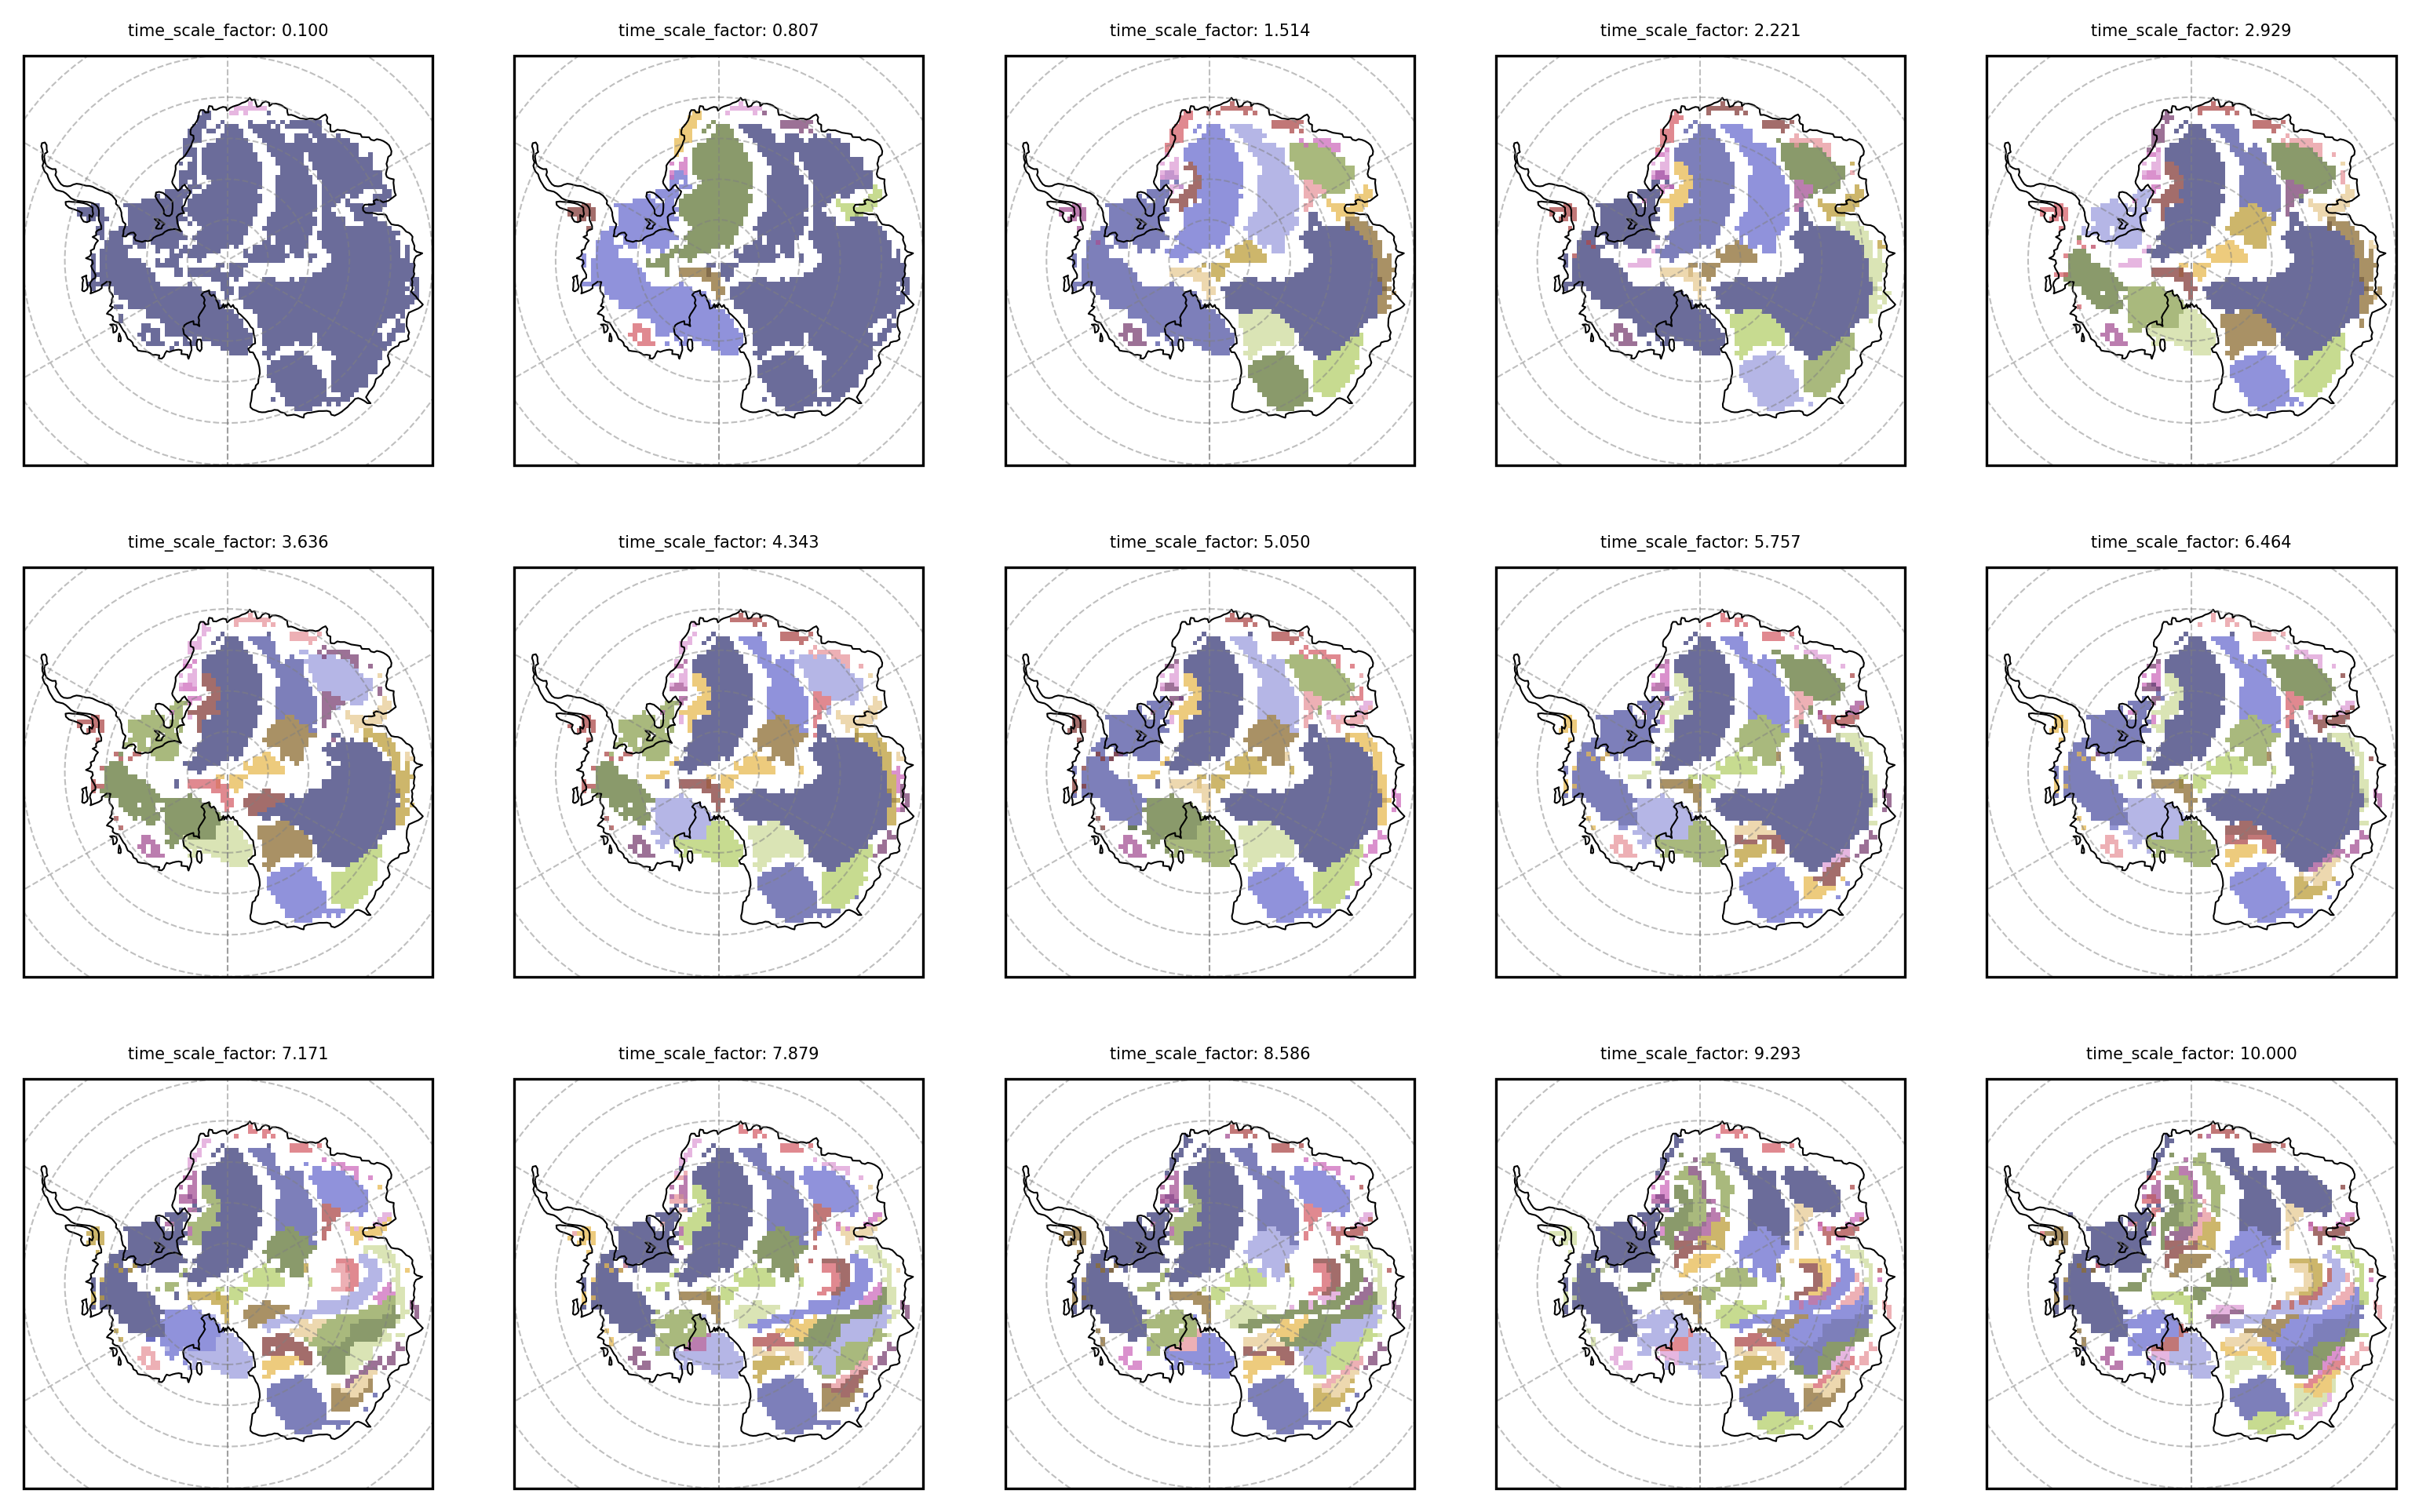

In [4]:
nrows = max(1, int(np.ceil(len(td.cluster_vars) / 5)))
fig, axs = td.plot.map(nrows, 5, projection="south_pole", figsize=(13, 8))
axs = axs.flatten()
for index, cvar in enumerate(td.cluster_vars):
    td.plot.cluster_map(
        cvar,
        projection="south_pole",
        ax=axs[index],
        add_labels=False,
        plot_contour=False,
    )
    axs[index].set_title(f"time_scale_factor: {(tsf_range[index]):.3f}", fontsize=5)

Compute two examples of aggregation measures


In [5]:
consistency = td.aggregation().cluster_consistency()
hist = td.aggregation().cluster_occurrence_rate()

Text(0.5, 1.0, 'Cluster Occurrence Rate')

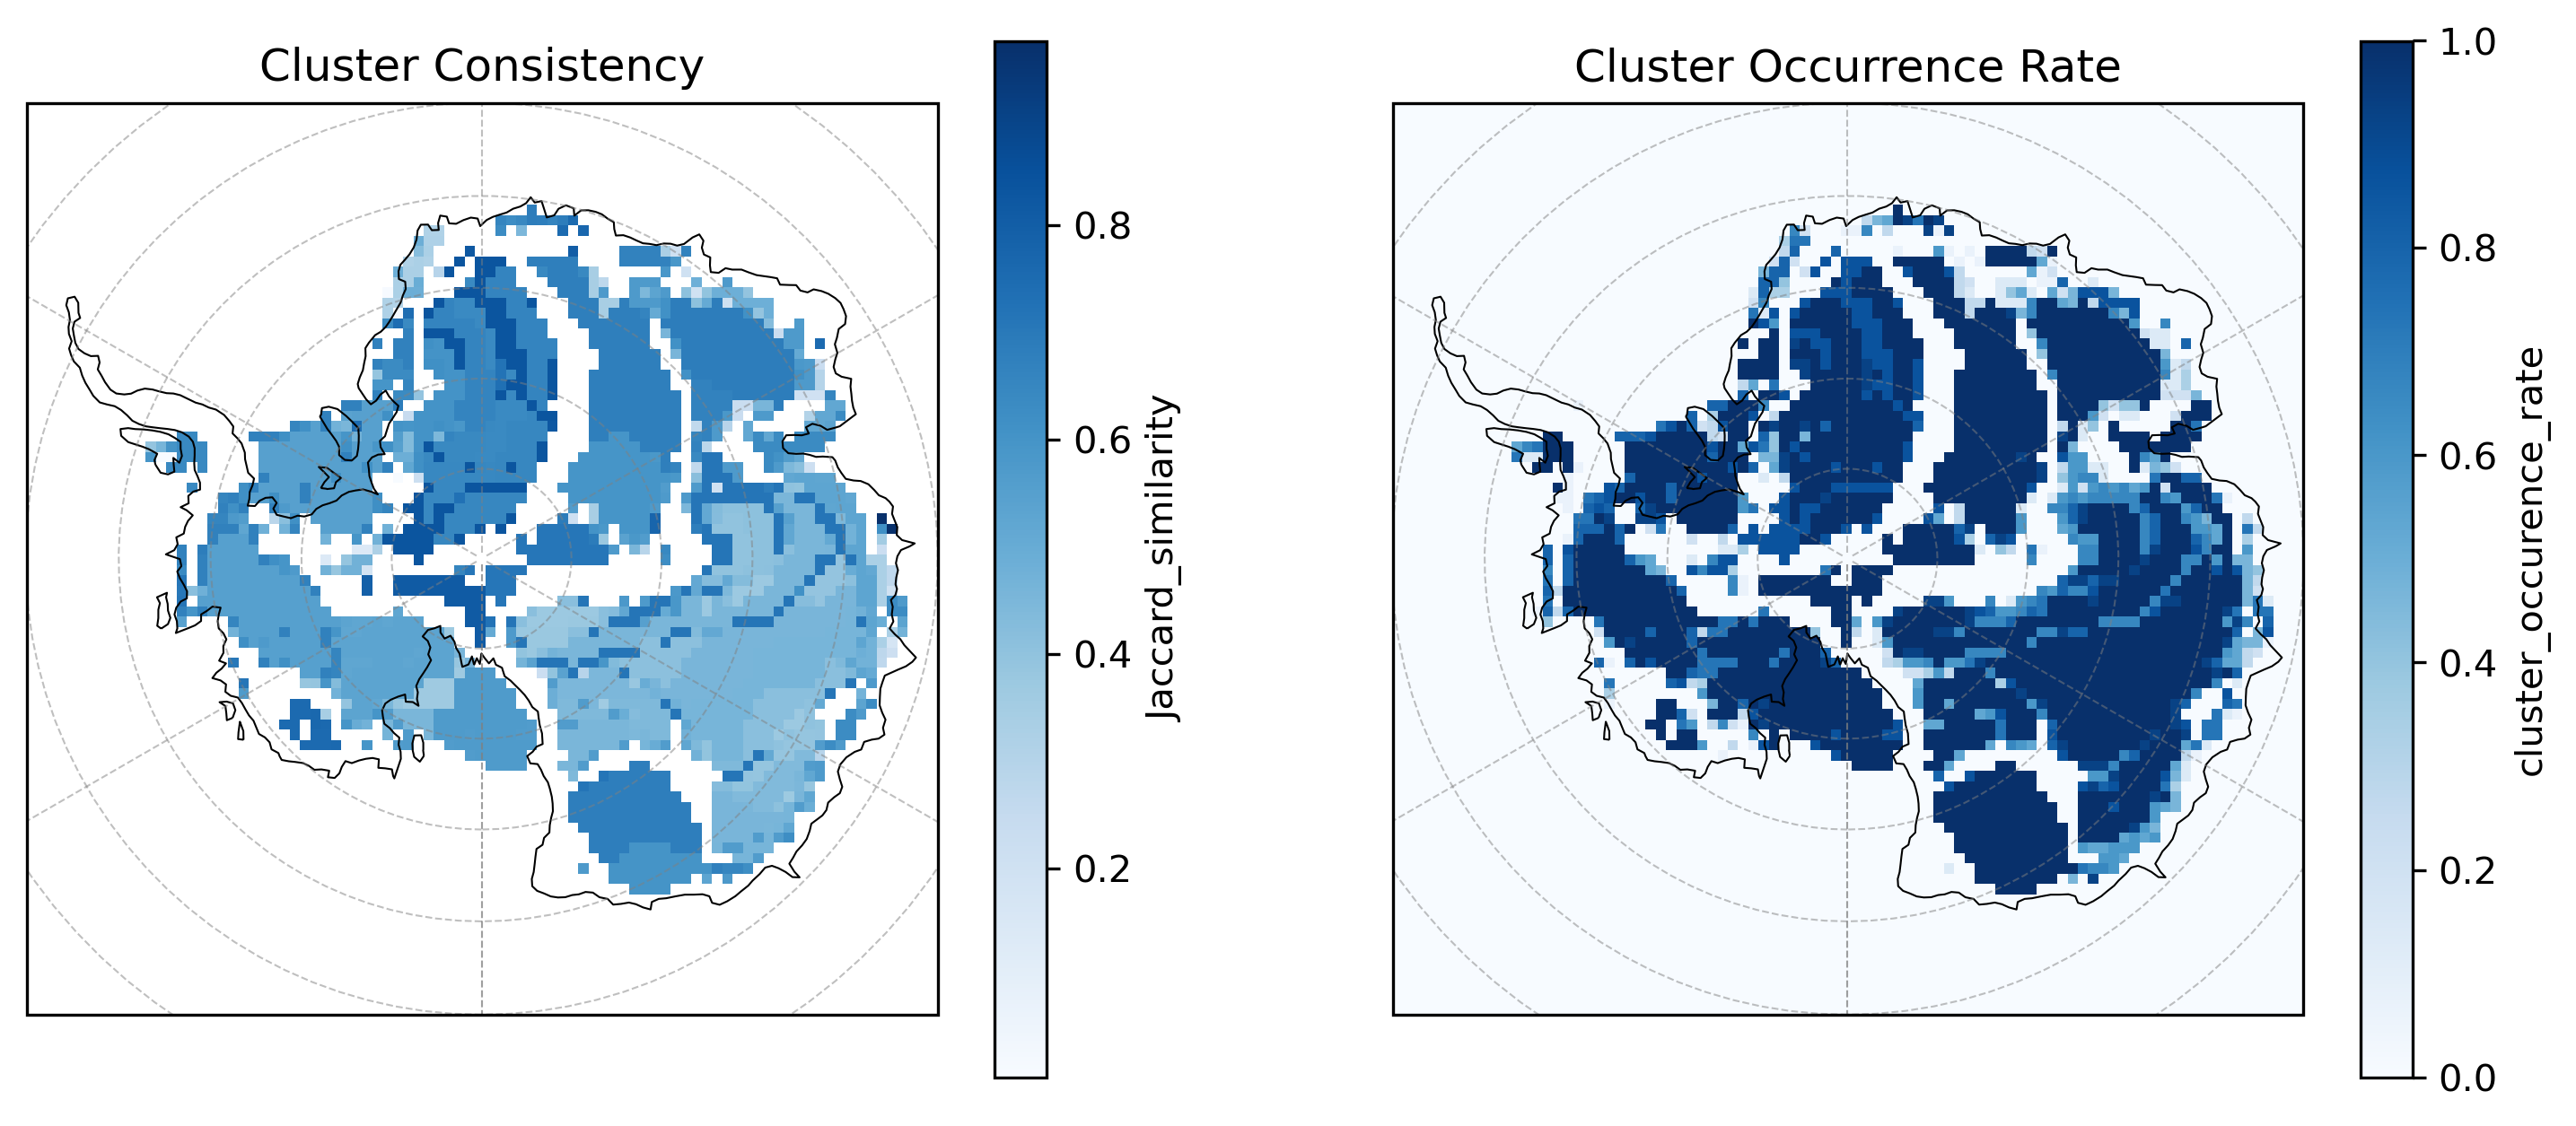

In [6]:
fig, axs = td.plot.map(1, 2, projection="south_pole")
consistency.plot(ax=axs[0], cmap="Blues")
hist.plot(ax=axs[1], cmap="Blues")
axs[0].set_title("Cluster Consistency")
axs[1].set_title("Cluster Occurrence Rate")

**Left: Cluster consistency, computed as the Jaccard similarity.** The value of each grid cell reflects how consistently it is clustered across the clusterings. If 1, a given grid cell is always clustered with the same neighbors. If 0, it is never clustered with the same neighbor more than once.

**Right: Cluster occurrence rate:** The value of each grid cell shows how often it is part of any cluster across the clusterings. If 1, the grid cell is clustered in every clustering, if 0, the grid cell is never part of a cluster.
